In [1]:
# %matplotlib nbagg -> Uncomment for viewing in notebook
import numpy as np
from scipy.spatial.distance import pdist, squareform
import random
from random import gauss, seed
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.animation as animation
import scipy.stats as ss
import seaborn as sns
import math
import pandas as pd
import copy

In [2]:
# Constants
graphlen = 10
boxlen = 7
fps = 10
m = [300,300,300]
f = 300
mu = 1200
sigma = 200
frames = 800
iterations = 10

In [3]:
def findAverage(runs):
    avg = []
    for i in range(0, len(runs[0])):
        avg.append(0)
        for j in range(0, len(runs)):
            avg[i] = avg[i] + runs[j][i]
        avg[i] = avg[i] / len(runs) 
    return avg

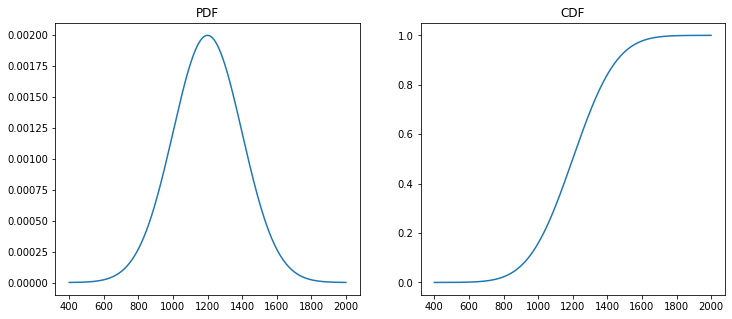

In [4]:
x = np.linspace(400, 2000, 5000)

pdf = ss.norm.pdf(x, mu, sigma) 
cdf = ss.norm.cdf(x, mu, sigma)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(x, pdf)
axes[1].plot(x, cdf)
axes[0].title.set_text('PDF')
axes[1].title.set_text('CDF')

In [5]:
# For making a permanent deep copy of user ratings across multiple simulations
user_ratings = []
for i in range(0, sum(m)+f):
    user_ratings.append(gauss(mu, sigma))

# copy.deepcopy(user_ratings) can be used to create a temporary copy

In [6]:
class Particle:
    def __init__(self, ID, gender, rating, group = 'normal'):
        self.ID = ID
        self.gender = gender
        self.elo = mu
        self.rating = rating
        self.left = {}
        self.right = {}
        self.rightswipes = 0
        self.leftswipes = 0
        self.group = group
    
    def connect(self, particle):
        if particle.gender == self.gender or self.filterEvaluation(particle.elo):
            return "None"
        if self.swipeLeftEvaluation(particle.rating):
            self.leftswipes += 1
            return "Left"
        self.rightswipes += 1
        return "Right"
    
    def update(self, particle, status):
        if status == "Left":
            self.left[particle.ID] = particle.elo
        if status == "Right":
            self.right[particle.ID] = particle.elo
        if status == "None":
            return
            
    def filterEvaluation(self, elo):
        return self.elo > (elo + 2*sigma)
    
    def computeElo(self):
        count = 0
        elo = 0
        for e in self.right.values():
            elo += (2*sigma + e)
            count += 1
        for e in self.left.values():
            elo += (e - 2*sigma)
            count += 1
        if count == 0:
            self.elo = mu
        else:
            self.elo = elo / count
        self.elo -= self.rightswipes * 5
        self.elo += len(self.right) * 10
    
    def swipeLeftEvaluation(self, rating):
        if self.group == 'allright':
            return False
        elif self.group == 'half':
            return random.uniform(0, 1) > 0.5
        return random.uniform(0, 1) > ss.norm.cdf(rating, self.rating, sigma)

In [7]:
class ParticleBox:
    def __init__(self,
                 init_state,
                 bounds = [-boxlen, boxlen, -boxlen, boxlen],
                 size = 0.04,
                 ratingarr = [],
                 logprogress = False):
        M = 0.05
        self.m_average_likes = [[],[],[]]
        self.f_average_likes = []
        self.m_average_elo = [[],[],[]]
        self.f_average_elo = []
        self.logprogress = logprogress
        self.init_state = np.asarray(init_state, dtype=float)
        self.M = M * np.ones(self.init_state.shape[0])
        self.size = size
        self.state = self.init_state.copy()
        self.time_elapsed = 0
        self.bounds = bounds
        self.particles = []
        for i in range(0, len(ratingarr)):
            if i < m[0]:
                self.particles.append(Particle(i, 'm', ratingarr[i], 'normal'))
            elif i < m[0] + m[1]:
                self.particles.append(Particle(i, 'm', ratingarr[i], 'half'))
            elif i < sum(m):
                self.particles.append(Particle(i, 'm', ratingarr[i], 'allright'))
            else:
                self.particles.append(Particle(i, 'f', ratingarr[i]))
    
    def log(self):
        if not self.logprogress:
            return
        m_likes = [0,0,0]
        f_likes = 0
        m_elo = [0,0,0]
        f_elo = 0
        for i in range(0, sum(m)+f):
            if i < m[0]:
                m_likes[0] += len(self.particles[i].right)
                m_elo[0] += self.particles[i].elo
            elif i < m[0] + m[1]:
                m_likes[1] += len(self.particles[i].right)
                m_elo[1] += self.particles[i].elo
            elif i < sum(m):
                m_likes[2] += len(self.particles[i].right)
                m_elo[2] += self.particles[i].elo
            else:
                f_likes += len(self.particles[i].right)
                f_elo += self.particles[i].elo

        self.m_average_likes[0].append(m_likes[0] / m[0])
        self.m_average_likes[1].append(m_likes[1] / m[1])
        self.m_average_likes[2].append(m_likes[2] / m[2])
        self.f_average_likes.append(f_likes / f)
        
        self.m_average_elo[0].append(m_elo[0] / m[0])
        self.m_average_elo[1].append(m_elo[1] / m[1])
        self.m_average_elo[2].append(m_elo[2] / m[2])
        self.f_average_elo.append(f_elo / f)
        
    def step(self, dt):
        self.log()
        self.time_elapsed += dt
        self.state[:, :2] += dt * self.state[:, 2:]
        
        D = squareform(pdist(self.state[:, :2]))
        ind1, ind2 = np.where(D < 2 * self.size)
        unique = (ind1 < ind2)
        ind1 = ind1[unique]
        ind2 = ind2[unique]

        for i1, i2 in zip(ind1, ind2):
            self.connect(i1, i2)
            
            # Perfectly elastic Collision
            m1 = self.M[i1]
            m2 = self.M[i2]
            
            r1 = self.state[i1, :2]
            r2 = self.state[i2, :2]

            v1 = self.state[i1, 2:]
            v2 = self.state[i2, 2:]

            r_rel = r1 - r2
            v_rel = v1 - v2

            v_cm = (m1 * v1 + m2 * v2) / (m1 + m2)

            # collisions of spheres reflect v_rel over r_rel
            rr_rel = np.dot(r_rel, r_rel)
            vr_rel = np.dot(v_rel, r_rel)
            v_rel = 2 * r_rel * vr_rel / rr_rel - v_rel

            # assign new velocities
            self.state[i1, 2:] = v_cm + v_rel * m2 / (m1 + m2)
            self.state[i2, 2:] = v_cm - v_rel * m1 / (m1 + m2) 
            
        # check for crossing boundary
        crossed_x1 = (self.state[:, 0] < self.bounds[0] + self.size)
        crossed_x2 = (self.state[:, 0] > self.bounds[1] - self.size)
        crossed_y1 = (self.state[:, 1] < self.bounds[2] + self.size)
        crossed_y2 = (self.state[:, 1] > self.bounds[3] - self.size)

        self.state[crossed_x1, 0] = self.bounds[0] + self.size
        self.state[crossed_x2, 0] = self.bounds[1] - self.size

        self.state[crossed_y1, 1] = self.bounds[2] + self.size
        self.state[crossed_y2, 1] = self.bounds[3] - self.size

        self.state[crossed_x1 | crossed_x2, 2] *= -1
        self.state[crossed_y1 | crossed_y2, 3] *= -1
    
    def connect(self, ind1, ind2):
        particle_a = self.particles[ind1]
        particle_b = self.particles[ind2]
        if particle_a.gender == particle_b.gender:
            return
        if particle_a.ID not in particle_b.left and particle_a.ID not in particle_b.right:
            a_swipe_b = particle_a.connect(particle_b)
            particle_b.update(particle_a, a_swipe_b)
        if particle_b.ID not in particle_a.left and particle_b.ID not in particle_a.right:
            b_swipe_a= particle_b.connect(particle_a)
            particle_a.update(particle_b, b_swipe_a)
        particle_a.computeElo()
        particle_b.computeElo()
        
    def plotDistributions(self):
        elos = []
        ratings = []
        for i in range(0, len(self.particles)):
            ratings.append(self.particles[i].rating)
            elos.append(self.particles[i].elo)
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
        sns.distplot(elos, hist=True, kde=False, 
             bins=int(180/5), color = 'blue', ax=axes[0],
             hist_kws={'edgecolor':'black'}).set_title("Empirical Elo Distribution")
        sns.distplot(ratings, hist=True, kde=False, 
             bins=int(180/5), color = 'blue', ax=axes[1],
             hist_kws={'edgecolor':'black'}).set_title("Empirical Rating Distribution")

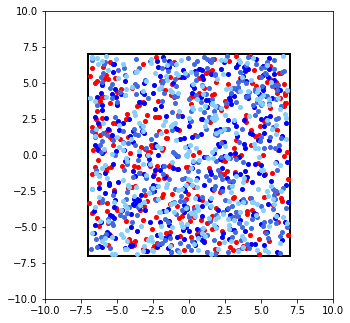

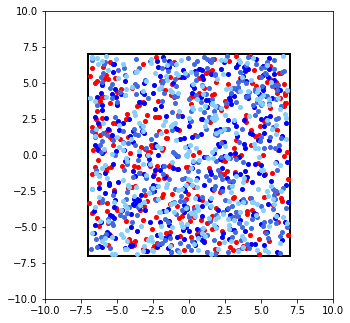

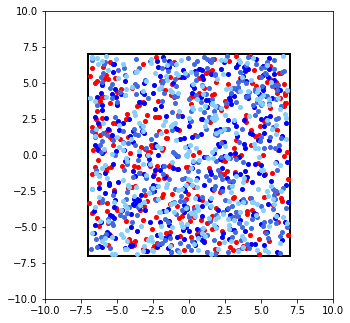

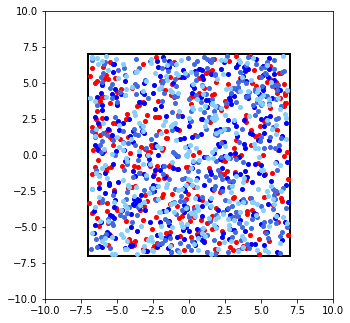

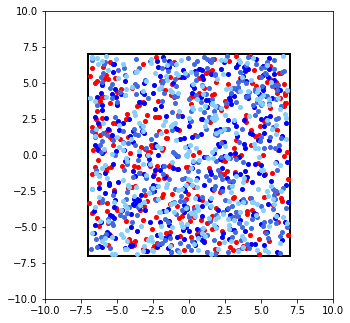

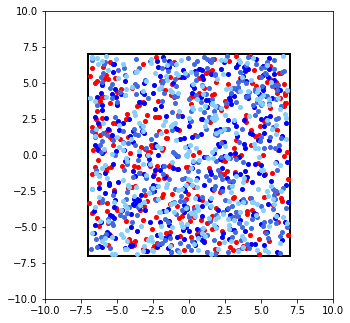

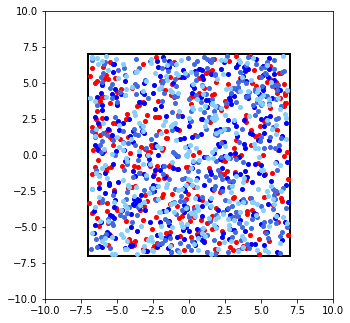

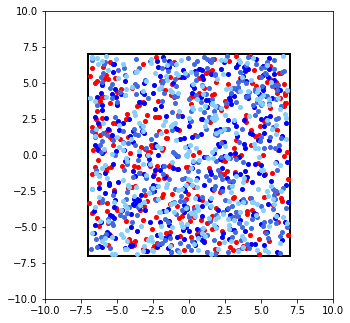

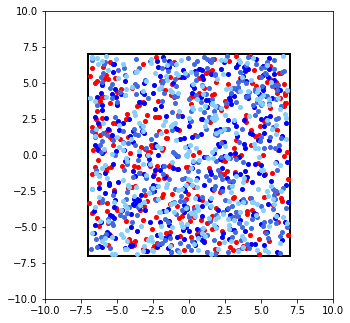

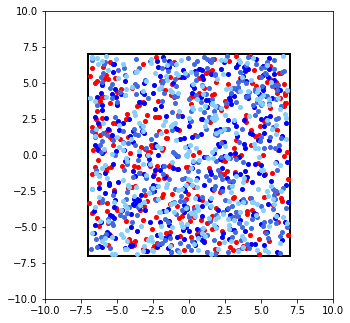

In [8]:
m_elo = [[],[],[]]
f_elo = []
m_likes = [[],[],[]]
f_likes = []
for i in range(0, iterations):
    # Rerun this block of code for repeated simulations
    ############################################################################################################
    np.random.seed(0)
    init_state = -0.5 + np.random.random((sum(m)+f, 4))
    init_state[:, :2] *= (boxlen*1.5)

    box = ParticleBox(init_state, size=0.1, ratingarr = copy.deepcopy(user_ratings), logprogress = True)
    dt = 1. / fps 

    # set up figure and animation
    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                         xlim=(-graphlen, graphlen), ylim=(-graphlen, graphlen))

    # particles holds the locations of the particles
    particles_f, = ax.plot([], [], 'ro', ms=4)
    particles_m1, = ax.plot([], [], 'o', color = 'blue', ms=4)
    particles_m2, = ax.plot([], [], 'o', color = 'royalblue', ms=4)
    particles_m3, = ax.plot([], [], 'o', color = 'lightskyblue', ms=4)

    # box edge
    rect = plt.Rectangle(box.bounds[::2],
                         box.bounds[1] - box.bounds[0],
                         box.bounds[3] - box.bounds[2],
                         ec='none', lw=2, fc='none')
    ax.add_patch(rect)

    def init():
        """initialize animation"""
        global box, rect
        particles_f.set_data([], [])
        particles_m1.set_data([], [])
        particles_m2.set_data([], [])
        particles_m3.set_data([], [])
        rect.set_edgecolor('none')
        return particles_f, particles_m1, particles_m2, particles_m3, rect

    def animate(i):
        """perform animation step"""
        global box, rect, dt, ax, fig
        box.step(dt)

        ms = int(fig.dpi * 2 * box.size * fig.get_figwidth()
                 / np.diff(ax.get_xbound())[0])

        # update pieces of the animation
        rect.set_edgecolor('k')
        particles_f.set_data(box.state[sum(m):, 0], box.state[sum(m):, 1])
        particles_f.set_markersize(ms)
        particles_m1.set_data(box.state[0:m[0], 0], box.state[0:m[0], 1])
        particles_m1.set_markersize(ms)
        particles_m2.set_data(box.state[m[0]:m[0] + m[1], 0], box.state[m[0]: m[0] + m[1], 1])
        particles_m2.set_markersize(ms)
        particles_m3.set_data(box.state[m[0] + m[1]:sum(m), 0], box.state[m[0] + m[1]:sum(m), 1])
        particles_m3.set_markersize(ms)
        return particles_f, particles_m1, particles_m2, particles_m3, rect

    ani = animation.FuncAnimation(fig, animate, frames=frames,
                                  interval=10, blit=True, init_func=init)
    writergif = animation.PillowWriter(fps=fps)
    ani.save('sim.gif',writer=writergif)

    # plt.show()
    m_elo[0].append(box.m_average_elo[0])
    m_elo[1].append(box.m_average_elo[1])
    m_elo[2].append(box.m_average_elo[2])
    f_elo.append(box.f_average_elo)
    m_likes[0].append(box.m_average_likes[0])
    m_likes[1].append(box.m_average_likes[1])
    m_likes[2].append(box.m_average_likes[2])
    f_likes.append(box.f_average_likes)

In [9]:
m1_iterated_elo = findAverage(m_elo[0])
m1_iterated_likes = findAverage(m_likes[0])
m2_iterated_elo = findAverage(m_elo[1])
m2_iterated_likes = findAverage(m_likes[1])
m3_iterated_elo = findAverage(m_elo[2])
m3_iterated_likes = findAverage(m_likes[2])
f_iterated_elo = findAverage(f_elo)
f_iterated_likes = findAverage(f_likes)

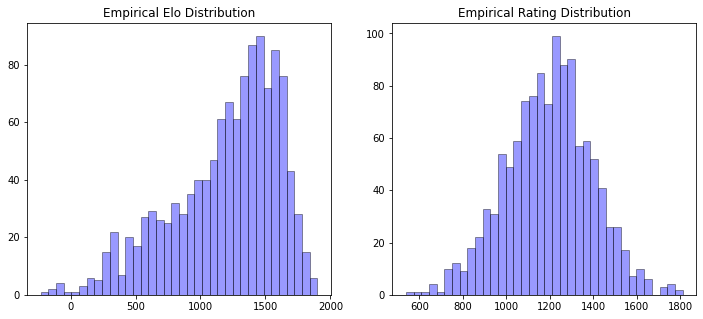

In [10]:
box.plotDistributions()

In [11]:
m_elosum = [0,0,0]
m_ratingsum = [0,0,0]
f_elosum = 0
f_ratingsum = 0
for i in range(0, sum(m)+f):
    if i < m[0]:
        m_elosum[0] += box.particles[i].elo
        m_ratingsum[0] += box.particles[i].rating
    elif i < m[0] + m[1]:
        m_elosum[1] += box.particles[i].elo
        m_ratingsum[1] += box.particles[i].rating
    elif i < m[0] + m[1] + m[2]:
        m_elosum[2] += box.particles[i].elo
        m_ratingsum[2] += box.particles[i].rating
    else:
        f_elosum += box.particles[i].elo
        f_ratingsum += box.particles[i].rating
    
print("Standard Elo avg = " + str(m_elosum[0] / m[0]))
print("Standard Rating avg = " + str(m_ratingsum[0] / m[0]))
print("Half Elo avg = " + str(m_elosum[1] / m[1]))
print("Half Rating avg = " + str(m_ratingsum[1] / m[1]))
print("Allright Elo avg = " + str(m_elosum[2] / m[2]))
print("Allright Rating avg = " + str(m_ratingsum[2] / m[2]))
print("Female Elo avg = " + str(f_elosum / f))
print("Female Rating avg = " + str(f_ratingsum / f))

Standard Elo avg = 1168.5324524984005
Standard Rating avg = 1188.465058593969
Half Elo avg = 1171.7371849446113
Half Rating avg = 1196.8357590554174
Allright Elo avg = 1074.2198687294606
Allright Rating avg = 1191.4079152906065
Female Elo avg = 1354.7586897278675
Female Rating avg = 1202.8271960384857


In [12]:
outperformance = 0
matches = 0
for i in range(0, m[0]):
    for right in box.particles[i].right.keys():
        if i in box.particles[right].right:
            outperformance += (box.particles[right].rating - box.particles[i].rating)
            matches += 1
print("Average match outperformance for standard (adjusted for rating delta): " + str(outperformance/matches - (f_ratingsum/f - m_ratingsum[0]/m[0])))
print("Average matches for standard: " + str(matches/m[0]))

outperformance = 0
matches = 0
for i in range(m[0], m[1] + m[2]):
    for right in box.particles[i].right.keys():
        if i in box.particles[right].right:
            outperformance += (box.particles[right].rating - box.particles[i].rating)
            matches += 1
print("Average match outperformance for half (adjusted for rating delta): " + str(outperformance/matches - (f_ratingsum/f - m_ratingsum[1]/m[1])))
print("Average matches for half: " + str(matches/m[1]))

outperformance = 0
matches = 0
for i in range(m[0] + m[1], sum(m)):
    for right in box.particles[i].right.keys():
        if i in box.particles[right].right:
            outperformance += (box.particles[right].rating - box.particles[i].rating)
            matches += 1
print("Average match outperformance for allright (adjusted for rating delta): " + str(outperformance/matches - (f_ratingsum/f - m_ratingsum[2]/m[2])))
print("Average matches for allright: " + str(matches/m[2]))

outperformance = 0
matches = 0
for i in range(sum(m), f+sum(m)):
    for right in box.particles[i].right.keys():
        if i in box.particles[right].right:
            outperformance += (box.particles[right].rating - box.particles[i].rating)
            matches += 1
print("Average outperformance in matches for females (adjusted for rating delta): " + str(outperformance/matches - (sum(m_ratingsum)/sum(m) - f_ratingsum/f)))
print("Average matches for females: " + str(matches/f))

Average match outperformance for standard (adjusted for rating delta): -21.927480472907437
Average matches for standard: 1.3666666666666667
Average match outperformance for half (adjusted for rating delta): -167.8954769804142
Average matches for half: 2.283333333333333
Average match outperformance for allright (adjusted for rating delta): -188.5111011925627
Average matches for allright: 4.42
Average outperformance in matches for females (adjusted for rating delta): 154.67596285670035
Average matches for females: 8.07


In [26]:
elodf = pd.DataFrame(
    {'Standard Elo': m1_iterated_elo,
     'Half Elo': m2_iterated_elo,
     'Allright Elo': m3_iterated_elo
     #'Female Elo': f_iterated_elo,
    })
elodf = elodf.transpose()

likedf = pd.DataFrame(
    {'Standard Elo': m1_iterated_likes,
     'Half Elo': m2_iterated_likes,
     'Allright Elo': m3_iterated_likes
     #'Female Elo': f_iterated_likes,
    })
likedf = likedf.transpose()

In [27]:
elodf.to_csv('elo.csv')
likedf.to_csv('likedf.csv')

<AxesSubplot:>

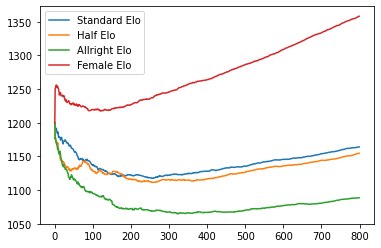

In [24]:
elodf.T.plot()

<AxesSubplot:>

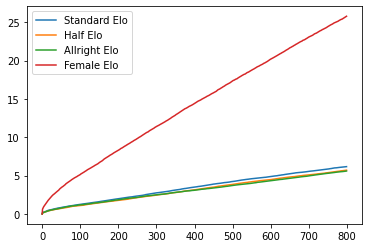

In [25]:
likedf.T.plot()